# Linear trend of global O2 dataset
- Include AOU and solubility to the analysis
- Linear trend from 1965 to 2020
- Vertical mean from 0-700m

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import gsw
from scipy import stats
from multiprocessing import pool
import cartopy.crs as ccrs

In [2]:
gver='1.2.G.1.1.1'

In [3]:
diro2='/glade/campaign/univ/ugit0034/ML4O2_results/'
dirTS='/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'

In [4]:
dm=xr.open_dataset('basin_mask_01.nc')
mask=dm.basin_mask.to_numpy()

In [5]:
ds=xr.open_dataset(diro2+f'O2map_v{gver}.nc')

In [6]:
Zref=1000
z = ds.depth.sel(depth=slice(0,Zref)).to_numpy()
z1=np.zeros(np.size(z)+1)
z1[1:]=z
dz=np.diff(z1)

In [7]:
weight=xr.DataArray(data=dz,dims=['depth'],coords={'depth':z})

In [21]:
o2w = ds.o2.sel(depth=slice(0,Zref)).weighted(weight).mean('depth')
aouw = ds.aou.sel(depth=slice(0,Zref)).weighted(weight).mean('depth')
solw = o2w + aouw

## calculate linear trend

In [10]:
def calc_Neff(X,Y):
    # lag1-autocorrelation for X
    tmp1=X[:-1]
    tmp2=X[1:]
    c=np.cov(tmp1,tmp2)
    r1=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    # lag1-autocorrelation for Y
    tmp1=Y[:-1]
    tmp2=Y[1:]
    c=np.cov(tmp1,tmp2)
    r2=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    # calculate Neff
    N=np.size(X)
    Neff = N*(1-r1*r2)/(1+r1*r2)
    if Neff > N:
        Neff = N
    return Neff

In [11]:
# define a function to calculate regression / correlation coefficients
def regrcorr(X,Y,CL):
    alp = 1-CL/100
    c=np.cov(X,Y)
    a=c[0,1]/c[0,0]
    b=np.mean(Y)-a*np.mean(X)
    r=c[0,1]/np.sqrt(c[0,0]*c[1,1])
    Neff=calc_Neff(X,Y)
    MSE = np.sum(((a*X+b) - Y)**2)/(Neff-2)
    SEa = np.sqrt( MSE/np.sum((X-np.mean(X))**2) )
    SEr = np.sqrt( (1-r**2)/(Neff-2) )
    ta=np.abs(a)/SEa
    tr=np.abs(r)/SEr
    tcrit=stats.t.ppf(1-alp/2,Neff-2)
    if ta>tcrit:
        sig_a = 1
    else:
        sig_a = 0
    if tr>tcrit:
        sig_r = 1
    else:
        sig_r = 0
    output=np.array([a,b,r,Neff,SEa,SEr,sig_a,sig_r])
    return output

In [12]:
def regrcorr_latlon(X,Y,CL):
    # loop over long and lat
    Ndata = np.shape(Y)
    Nx = Ndata[2]
    Ny = Ndata[1]
    output = np.zeros((8,Ny,Nx))
    for nx in range(Nx):
        for ny in range(Ny):
            Ylocal=Y[:,ny,nx]
            output_local = regrcorr(X,Ylocal,CL)
            output[:,ny,nx]=output_local
    return output

In [37]:
## calling the regrcorr_latlon function
#time = np.arange(1970,2011,1/12)
#output = regrcorr_latlon(time,o2w[60:(672-120),:,:].to_numpy(),95)
#output1 = regrcorr_latlon(time,solw[60:(672-120),:,:].to_numpy(),95)
#output2 = regrcorr_latlon(time,-aouw[60:(672-120),:,:].to_numpy(),95)
#
time = np.arange(1965,2021,1/12)
output = regrcorr_latlon(time,o2w.to_numpy(),95)
output1 = regrcorr_latlon(time,solw.to_numpy(),95)
output2 = regrcorr_latlon(time,-aouw.to_numpy(),95)

In [38]:
## xx and yy  are 2dim version of long and lat
step = 5
xx,yy=np.meshgrid(ds.lon[::step],ds.lat[::step])

## select long and lat where regr coeff is significant
xxa=xx[output[6,::step,::step]==1]
yya=yy[output[6,::step,::step]==1]

## select long and lat where corr coeff is significant
xxr=xx[output[7,::step,::step]==1]
yyr=yy[output[7,::step,::step]==1]

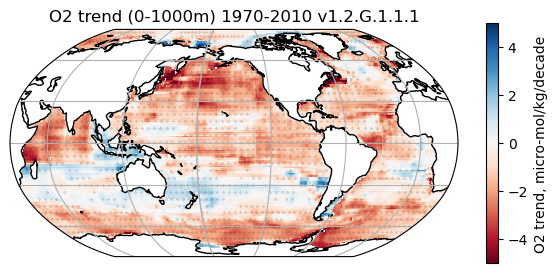

In [39]:
fig=plt.figure(figsize=(7,6))
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Robinson(central_longitude=-150))
im = ax.pcolormesh(ds.lon,ds.lat,output[0,:,:]*10,cmap='RdBu',vmin=-5,vmax=5,
              transform=ccrs.PlateCarree())
ax.plot(xxa,yya,'.',transform=ccrs.PlateCarree(),
         markersize=.3,color='k',alpha=.8)
ax.coastlines()
ax.gridlines()
ax.set_title(f'O2 trend (0-{Zref}m) 1970-2010 v{gver}')
plt.colorbar(im,ax=ax,location='right',shrink=.5,label='O2 trend, micro-mol/kg/decade')
plt.savefig(f'O2_trend_0-{Zref}m_v{gver}.pdf',bbox_inches='tight')

In [40]:
## xx and yy  are 2dim version of long and lat
step = 5
xx,yy=np.meshgrid(ds.lon[::step],ds.lat[::step])

## select long and lat where regr coeff is significant
xxa=xx[output1[6,::step,::step]==1]
yya=yy[output1[6,::step,::step]==1]

## select long and lat where corr coeff is significant
xxr=xx[output1[7,::step,::step]==1]
yyr=yy[output1[7,::step,::step]==1]

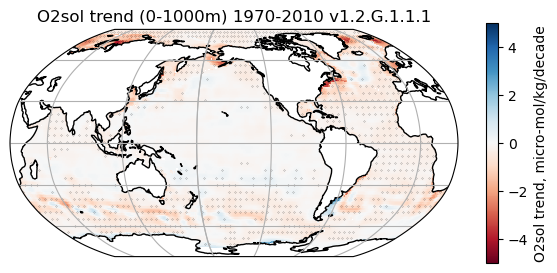

In [41]:
fig=plt.figure(figsize=(7,6))
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Robinson(central_longitude=-150))
im = ax.pcolormesh(ds.lon,ds.lat,output1[0,:,:]*10,cmap='RdBu',vmin=-5,vmax=5,
              transform=ccrs.PlateCarree())
ax.plot(xxa,yya,'.',transform=ccrs.PlateCarree(),
         markersize=.3,color='k',alpha=.8)
ax.coastlines()
ax.gridlines()
ax.set_title(f'O2sol trend (0-{Zref}m) 1970-2010 v{gver}')
plt.colorbar(im,ax=ax,location='right',shrink=.5,label='O2sol trend, micro-mol/kg/decade')
plt.savefig(f'O2sol_trend_0-{Zref}m_v{gver}.pdf',bbox_inches='tight')

In [42]:
## xx and yy  are 2dim version of long and lat
step = 5
xx,yy=np.meshgrid(ds.lon[::step],ds.lat[::step])

## select long and lat where regr coeff is significant
xxa=xx[output2[6,::step,::step]==1]
yya=yy[output2[6,::step,::step]==1]

## select long and lat where corr coeff is significant
xxr=xx[output2[7,::step,::step]==1]
yyr=yy[output2[7,::step,::step]==1]

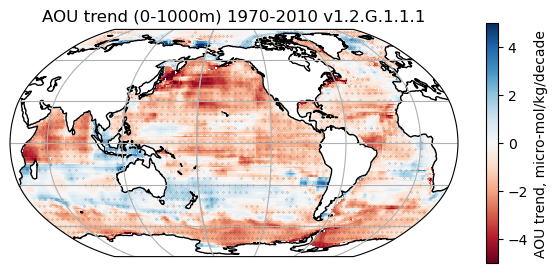

In [43]:
fig=plt.figure(figsize=(7,6))
ax=fig.add_axes([.1,.1,.8,.8],projection=ccrs.Robinson(central_longitude=-150))
im = ax.pcolormesh(ds.lon,ds.lat,output2[0,:,:]*10,cmap='RdBu',vmin=-5,vmax=5,
              transform=ccrs.PlateCarree())
ax.plot(xxa,yya,'.',transform=ccrs.PlateCarree(),
         markersize=.3,color='k',alpha=.8)
ax.coastlines()
ax.gridlines()
ax.set_title(f'AOU trend (0-{Zref}m) 1970-2010 v{gver}')
plt.colorbar(im,ax=ax,location='right',shrink=.5,label='AOU trend, micro-mol/kg/decade')
plt.savefig(f'AOU_trend_0-{Zref}m_v{gver}.pdf',bbox_inches='tight')